# OFDM system implementation

In this assignment, you will implement an OFDM transmitter+receiver like shown in
Fig. 1 in python in a jupyter notebook. Send me your results as a compressed zip
file via email. Make sure to provide a logical step wise documentation, by defining
and introducing all the variables you require. Define a function for each block in the
OFDM block diagram. Assume that c(τ) = δ(τ) and begin by neglecting the additive
noise. Verify and test each function by calling your implemented functions for input of
your choice. Use the steps below as an aid.

![OFDM block diagram](./ofdm.png)

a) Import the following libraries: numpy as np and matplotlib.pyplot as plt.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configure the random number generator (RNG).
rng = np.random.default_rng()

b) Generate a random bitstream b[k], ∀ 0 ≤ k ≤ K via a function called bit_source(Ns) that returns the bitstream.

In [2]:
def bit_source(Ns):
    # Generate random bit sequence of length Ns.
    return np.random.randint(0, 2, Ns)

assert len(bit_source(42)) == 42, "Generated bit sequence does not have the same length!"

c) Define a function implementing the modulation called map_bpsk(b) returning the modulated signal by mapping the 0 → 1 and 1 → −1.

In [3]:
def map_bpsk(b):
    # Remap every 0 -> 1 and 1 -> -1.
    temp = np.copy(b)
    temp[temp == 1] = -1
    temp[temp == 0] = 1
    return temp

assert np.array_equal(map_bpsk([0, 1, 1, 1, 0, 0, 1, 0]), [1, -1, -1, -1, 1, 1, -1, 1]), "Mapping via binary phase shift keying implementation invalid!"

def unmap_bpsk(b):
    # Remap every 1 -> 0 and -1 -> 1.
    temp = np.real(np.copy(b))
    temp[temp == 1] = 0
    temp[temp == -1] = 1
    return temp

assert np.array_equal(unmap_bpsk([1, -1, -1, -1, 1, 1, -1, 1]), [0, 1, 1, 1, 0, 0, 1, 0]), "Unmapping via binary phase shift keying implementation invalid!"

def detect(b):
    temp = np.copy(b)
    temp[temp > 0] = 1
    temp[temp <= 0] = -1
    return temp

assert np.array_equal(detect([1.25, .5, .25, 0, -1, -.5, -.25, 0]), [1, 1, 1, -1, -1, -1, -1, -1]), "Detecting implementation invalid!"

def modulate(symbols):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    output = np.zeros(temp.shape, dtype=np.complex)
    
    for symbol in range(symbol_count):
        output[symbol,:] = map_bpsk(temp[symbol,:])
        
    return output
        
assert np.array_equal(modulate([[0, 1], [1, 0]]), [[1, -1], [-1, 1]]), "Modulation implementation invalid!"

def demodulate(symbols):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    output = np.zeros(temp.shape, dtype=np.complex)
    
    for symbol in range(symbol_count):
        output[symbol,:] = unmap_bpsk(temp[symbol,:])
        
    return output
        
assert np.array_equal(demodulate([[1, -1], [-1, 1]]), [[0, 1], [1, 0]]), "Demodulation implementation invalid!"

d) Implement IDFT/IFFT or DFT/FFT.

In [4]:
def pad(symbol, width):
    temp = np.copy(symbol)
    length = temp.shape[0]
    padding = np.zeros(width-length)
    return np.insert(temp, np.floor(length/2).astype(np.int), padding, axis=0)

assert np.array_equal(pad([1, 2, 3], 6), [1, 0, 0, 0, 2, 3]), "Padding implementation invalid!"
    
def unpad(symbol, width):
    temp = np.copy(symbol)
    length = temp.shape[0]
    middle = np.floor(length/2).astype(np.int)
    diff = length-width
    remove_range = np.arange(np.floor(middle-diff/2), np.floor(middle+diff/2)).astype(np.int)
    return np.delete(temp, remove_range, axis=0)

assert np.array_equal(unpad(np.array([1, 0, 0, 0, 2, 3]), 3), [1, 2, 3]), "Unpadding implementation invalid!"

def ifft(symbols):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    output = np.zeros(temp.shape, dtype=np.complex)
    
    for symbol in range(symbol_count):
        output[symbol,:] = np.fft.ifft(temp[symbol,:])
    
    return output

def fft(symbols):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    output = np.zeros(temp.shape, dtype=np.complex)
    
    for symbol in range(symbol_count):
        output[symbol,:] = np.fft.fft(temp[symbol,:])
    
    return output

assert np.array_equal(fft(ifft([[1, -1], [-1, 1]])), [[1, -1], [-1, 1]]), "IFFT or FFT implementation invalid!"

e) Implement functions needed for the cyclic prefix, the serial-to-parallel-conversion and the parallel-to-serial-conversion.

In [5]:
def next_power2(x):
    return np.power(2, np.ceil(np.log2(x))).astype(np.int)

assert next_power2(2) == 2, "Next power of 2 implementation invalid!"
assert next_power2(3) == 4, "Next power of 2 implementation invalid!"
assert next_power2(4) == 4, "Next power of 2 implementation invalid!"
assert next_power2(5) == 8, "Next power of 2 implementation invalid!"
assert next_power2(9) == 16, "Next power of 2 implementation invalid!"

def sipo(bitstream, data_width, padded_width):
    temp = np.copy(bitstream)
    symbol_count = np.ceil(temp.shape[0]/data_width).astype(np.int)
    output = np.zeros((symbol_count, padded_width), dtype=np.complex)
    
    for symbol in range(symbol_count):
        first = symbol*data_width
        last = first+data_width
        output[symbol] = pad(temp[first:last], padded_width)
        
    return output

assert np.array_equal(sipo([1, 2, 3, 4, 5, 6, 7, 8, 9], 3, 4), [[1, 0, 2, 3], [4, 0, 5, 6], [7, 0, 8, 9]]), "Serial to parallel conversion implementation invalid!"

def piso(symbols, data_width):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    output = np.zeros(symbol_count*data_width, dtype=np.complex)
    
    for symbol in range(symbol_count):
        first = symbol*data_width
        last = first+data_width
        output[first:last] = unpad(temp[symbol], data_width)
        
    return output

assert np.array_equal(piso([[1, 0, 2, 3], [4, 0, 5, 6], [7, 0, 8, 9]], 3), [1, 2, 3, 4, 5, 6, 7, 8, 9]), "Parallel to serial conversion implementation invalid!"

def add_cyclic_prefix(symbols, prefix_length):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    symbol_size = temp.shape[1]
    output = np.zeros((symbol_count, symbol_size+prefix_length), dtype=np.complex)
    
    for symbol in range(symbol_count):
        output[symbol,:] = np.concatenate((temp[symbol,-prefix_length:], temp[symbol,:]))
        
    return output

assert np.array_equal(add_cyclic_prefix([[1, 2, 3, 4], [5, 6, 7, 8]], 2), [[3, 4, 1, 2, 3, 4], [7, 8, 5, 6, 7, 8]]), "Cylic prefix adding implementation invalid!"

def remove_cyclic_prefix(symbols, prefix_length):
    temp = np.copy(symbols)
    symbol_count = temp.shape[0]
    symbol_size = temp.shape[1]
    output = np.zeros((symbol_count, symbol_size-prefix_length), dtype=np.complex)
    
    for symbol in range(symbol_count):
        output[symbol,:] = temp[symbol,prefix_length:symbol_size]
        
    return output

assert np.array_equal(remove_cyclic_prefix([[3, 4, 1, 2, 3, 4], [7, 8, 5, 6, 7, 8]], 2), [[1, 2, 3, 4], [5, 6, 7, 8]]), "Cylic prefix removing implementation invalid!"

f) Write a function called bit_error_rate(input, output) that compares your input
data vector with your output data vector and counts the bit errors in case the
vector elements are pairwise not the same. The function should return that count
divided by the vector length.

In [6]:
def bit_error_rate(reference, detected):
    # Computes the bit error rate (BER) by comparing the input to the output.
    errors = np.equal(reference, detected)
    return np.sum(np.invert(errors))/errors.shape[0]

assert np.isclose(bit_error_rate([1, 0, 1, 0, 1, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 0, 1, 0, 1, 1]), 0.1), "Bit error rate implementation invalid."

In [7]:
def add_gaussian_noise(bitstream, snr_db):
    temp = np.copy(bitstream)
    noise = np.sqrt(10**(-snr_db/10))*rng.standard_normal(temp.shape)
    return temp+noise

In [8]:
def wireless_channel(bitstream, subcarrier_count, prefix_length, snr_db = 200, debug=False):
    # Define system parameters.
    symbol_width = next_power2(subcarrier_count)
    padded_symbol_width = symbol_width+prefix_length
    
    # Create a copy of the original data.
    snd_data = np.copy(bitstream)
    if debug:
        print("[SND] Data:")
        print(snd_data)
        print()
        
    # Parallelize the data into symbols and pad it to have a subcarrier count that is a power of 2.
    snd_parallelized_and_padded_symbols = sipo(snd_data, subcarrier_count, symbol_width)
    if debug:
        print("[SND] Parallelized and padded:")
        print(snd_parallelized_and_padded_symbols)
        print()
    
    # Modulate the data symbols via BPSK (binary phase shift keying).
    snd_modulated_symbols = modulate(snd_parallelized_and_padded_symbols)
    if debug:
        print("[SND] Modulated:")
        print(snd_modulated_symbols)
        print()
    
    # Apply inverse fast Fourier transform.
    snd_ifft_symbols = ifft(snd_modulated_symbols)
    if debug:
        print("[SND] IFFT:")
        print(snd_ifft_symbols)
        print()
        
    # Add cyclic prefix.
    snd_cyclic_prefix_symbols = add_cyclic_prefix(snd_ifft_symbols, prefix_length)
    if debug:
        print("[SND] With cyclic prefix:")
        print(snd_cyclic_prefix_symbols)
        print()
        
    # Convert to serial for transmission.
    snd_serialized = piso(snd_cyclic_prefix_symbols, padded_symbol_width)
    if debug:
        print("[SND] Serialized:")
        print(snd_serialized)
        print()
        
    # Add noise.
    air_data = add_gaussian_noise(snd_serialized, snr_db)
    if debug:
        print("[AIR] Data:")
        print(air_data)
        print()
        
    # Convert to parallel to remove cyclic prefix.
    rcv_parallelized_symbols = sipo(air_data, padded_symbol_width, padded_symbol_width)
    if debug:
        print("[RCV] Parallelized:")
        print(rcv_parallelized_symbols)
        print()
        
    # Remove cyclic prefix.
    rcv_cyclic_prefix_symbols = remove_cyclic_prefix(rcv_parallelized_symbols, prefix_length)
    if debug:
        print("[RCV] Without cyclic prefix:")
        print(rcv_cyclic_prefix_symbols)
        print()
        
    # Apply fast Fourier transform.
    rcv_fft_symbols = fft(rcv_cyclic_prefix_symbols)
    if debug:
        print("[RCV] FFT:")
        print(rcv_fft_symbols)
        print()
        
    # Detect data signals.
    rcv_detected = detect(rcv_fft_symbols)
    if debug:
        print("[RCV] Detected:")
        print(rcv_detected)
        print()
        
    # Demodulate signal.
    rcv_demodulated_symbols = demodulate(rcv_detected)
    if debug:
        print("[RCV] Demodulated:")
        print(rcv_demodulated_symbols)
        print()
    
    # Unpadded serialized data.
    rcv_serialized_and_unpadded = piso(rcv_demodulated_symbols, subcarrier_count)
    if debug:
        print("[RCV] Serialized and unpadded:")
        print(rcv_serialized_and_unpadded)
        print()
        
    # Received data.
    rcv_data = np.real(rcv_serialized_and_unpadded).astype(np.int)
    if debug:
        print("[RCV] Data:")
        print(rcv_data)
        print()
    
    return rcv_data, bit_error_rate(snd_data, rcv_data)

g) Test your system functions by using a deterministic input sequence of your choice and then by using the random bitstream by running it a multiple times (for instance runs=1000 in a for loop) on random input data sequences and now also add additive white gaussian noise to the received values each time. Calculate the SNR = 1/$σ_n^2$, where $σ_n^2$ is the noise variance of the additive white Gaussian noise. Simulate your results for different [SNR] in dB = [0, 2, ..., 20]. Accumulate the bit error for every SNR in every run (after your for loop for the runs). Then divide that error by the number of runs. Finally, plot the bit error-rate versus the SNR in dB and apply a logarithmic axis to the plot yaxis. Furthermore, make sure, that the plot has the form you expect it to have, and use grid lines, a title, a legend and axis labels for your plot (fontsize > 24).

In [9]:
# Deterministic input sequence.
det_in = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
det_out, det_ber = wireless_channel(det_in, 10, 2)

print("[SND] Data:", det_in)
print("[RCV] Data:", det_out)
print("[BER] %.2f%%"%(100*det_ber))

assert np.array_equal(det_in, det_out), "[DET] OFDM implementation invalid!"

[SND] Data: [1 0 1 0 1 0 1 0 1 0]
[RCV] Data: [1 0 1 0 1 0 1 0 1 0]
[BER] 0.00%


In [10]:
# Random input sequence.
rand_in = bit_source(5000)
rand_out, rand_ber = wireless_channel(rand_in, 10, 2)

assert np.array_equal(rand_in, rand_out), "[RND] OFDM implementation invalid!"

In [11]:
# Simulate wireless channel multiple times.
sim_count = 100
subchannel_count = 10
prefix_length = subchannel_count//4
sample_count = subchannel_count*100
snrs = np.arange(0, 22, 2)
bers = []

for snr in snrs:
    accumulated_bit_error_rate = 0
    
    for sim in range(sim_count):
        sim_in = bit_source(sample_count)
        sim_out, sim_ber = wireless_channel(sim_in, subchannel_count, prefix_length, snr)
        accumulated_bit_error_rate += sim_ber
        
    accumulated_bit_error_rate /= sim_count
    bers.append(accumulated_bit_error_rate)
    print("SNR: %sdB    BER: %2.2f%%"%(str(snr).rjust(2, ' '), accumulated_bit_error_rate*100))


SNR:  0dB    BER: 36.68%
SNR:  2dB    BER: 33.61%
SNR:  4dB    BER: 29.44%
SNR:  6dB    BER: 25.10%
SNR:  8dB    BER: 19.48%
SNR: 10dB    BER: 13.85%
SNR: 12dB    BER: 8.71%
SNR: 14dB    BER: 4.43%
SNR: 16dB    BER: 1.82%
SNR: 18dB    BER: 0.46%
SNR: 20dB    BER: 0.07%


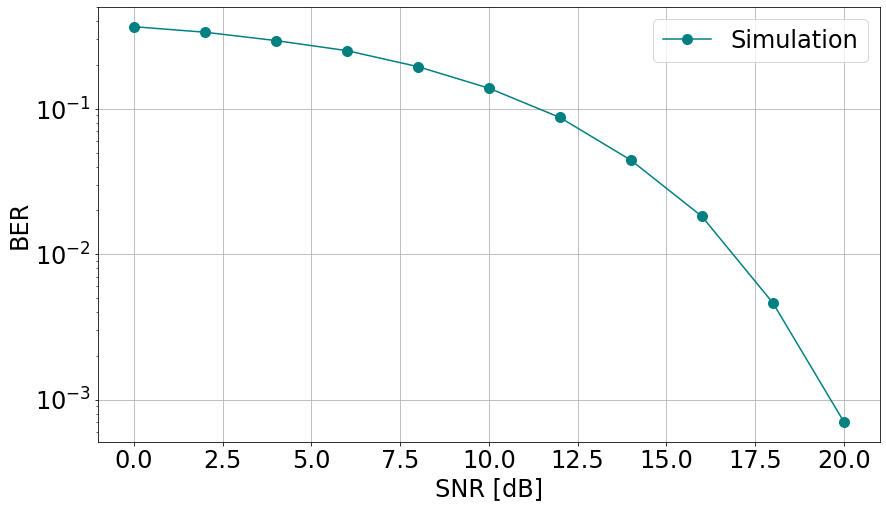

In [12]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(figsize=(14,8))
ax.semilogy(snrs, bers, label='Simulation', color='teal', marker='o', markersize=10)
ax.set_xlabel(xlabel='SNR [dB]')
ax.set_ylabel(ylabel='BER')
ax.grid(True)
ax.legend();